In [2]:
import os, time, h5py
from tqdm import tqdm
import numpy as np
from scipy import ndimage
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

def check_torch():
    torch_version, cuda_avail = torch.__version__, torch.cuda.is_available()
    count, name = torch.cuda.device_count(), torch.cuda.get_device_name()
    device = torch.device('cuda' if cuda_avail else 'cpu')
    print('-'*60)
    print('----------------------- VERSION INFO -----------------------')
    print('Torch version: {} | Torch Built with CUDA? {}'.format(torch_version, cuda_avail))
    print('# Device(s) available: {}, Name(s): {}'.format(count, name))
    print('-'*60)
    return device

device = check_torch()
cmap, interp = 'binary', 'bicubic'

------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.7.1+cu126 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3090
------------------------------------------------------------


In [3]:
with h5py.File('data/facies.h5', 'r') as f:
    facies = f['facies'][:]
print('Facies shape: {}'.format(facies.shape))

Facies shape: (318, 256, 256, 128)


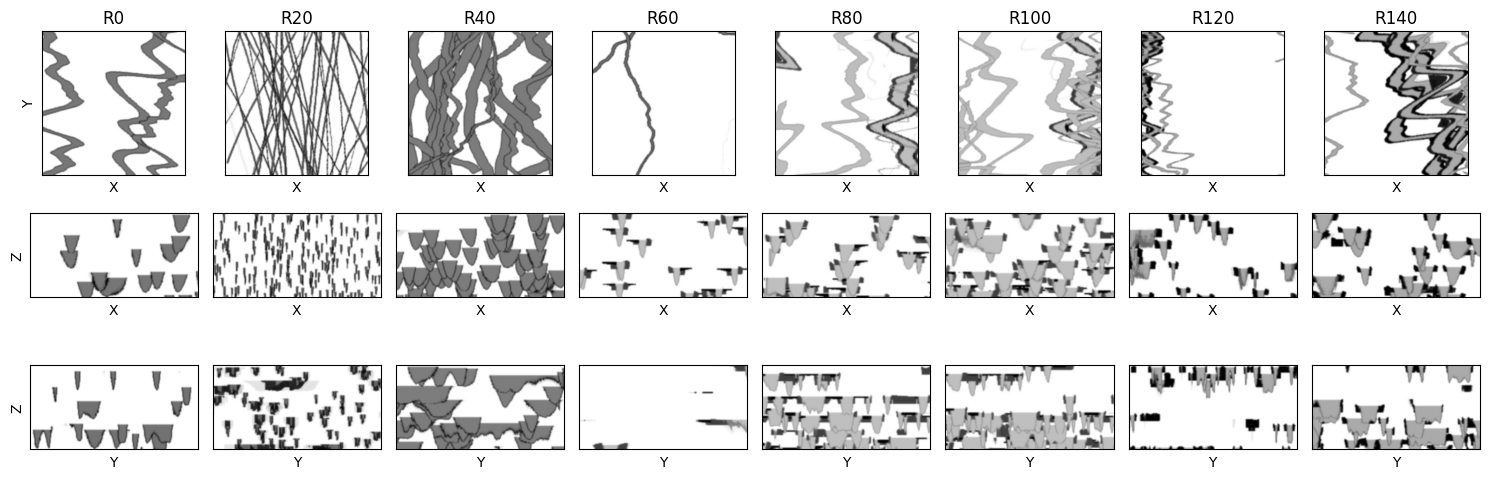

In [4]:
mult = 20
fig, axs = plt.subplots(3, 8, figsize=(15,5))
for j in range(8):
    ax1, ax2, ax3 = axs[:,j]
    db = ndimage.gaussian_filter(facies[j*mult], sigma=0.5)
    im1 = ax1.imshow(db[...,64], cmap=cmap, interpolation=interp)
    im2 = ax2.imshow(db[128].T, cmap=cmap, interpolation=interp)
    im3 = ax3.imshow(db[:,128].T, cmap=cmap, interpolation=interp)
    for i in range(3):
        axs[i,j].set(xticks=[], yticks=[])
    ax1.set(title='R{}'.format(j*mult))
    ax1.set(xlabel='X', ylabel='Y' if j==0 else None)
    ax2.set(xlabel='X', ylabel='Z' if j==0 else None)
    ax3.set(xlabel='Y', ylabel='Z' if j==0 else None)
plt.tight_layout()
plt.show()

In [60]:
sample = 250
nwells = 5
extent = (15, 255-16)

# Wells (x,y) coordinates
depth = np.arange(facies[sample].shape[-1]) + 1000
nz = len(depth)
wx, wy = np.random.randint(extent[0], extent[1], size=(2,nwells))
print('Wells (x,y): ({}, {})'.format(wx, wy))

# Well logs (clean, noisy)
well_log = facies[sample, wy, wx, :]
noise_log = facies[sample, wy, wx, :] + np.random.normal(0, 0.2*facies[sample].std(), facies[sample].shape[-1])
wscale = 3

Wells (x,y): ([237 195 168 129  89], [ 35 198 177  98 192])


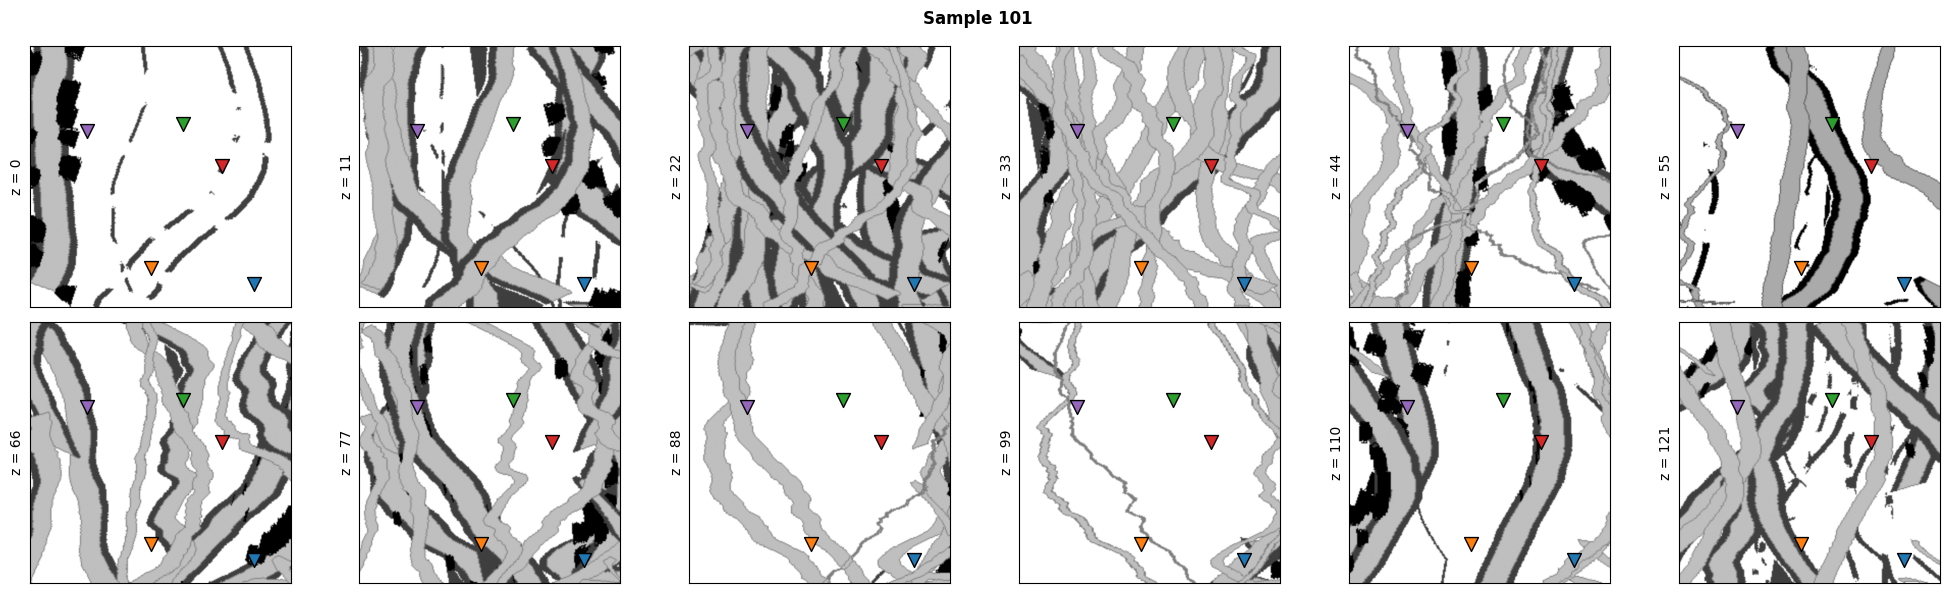

In [6]:
plt.figure(figsize=(20,6))
for i in range(12):
    plt.subplot(2, 6, i+1)
    k = i * 11
    plt.imshow(facies[sample,...,k], cmap=cmap, interpolation=interp)
    [plt.scatter(wx[i], wy[i], marker='v', edgecolor='k', c='C{}'.format(i), s=100) for i in range(nwells)]
    plt.xticks([]); plt.yticks([])
    plt.ylabel('z = {}'.format(k))
plt.suptitle('Sample {}'.format(sample), weight='bold')
plt.tight_layout()
plt.savefig('figures/aerial-wells.png', dpi=600)
plt.show()

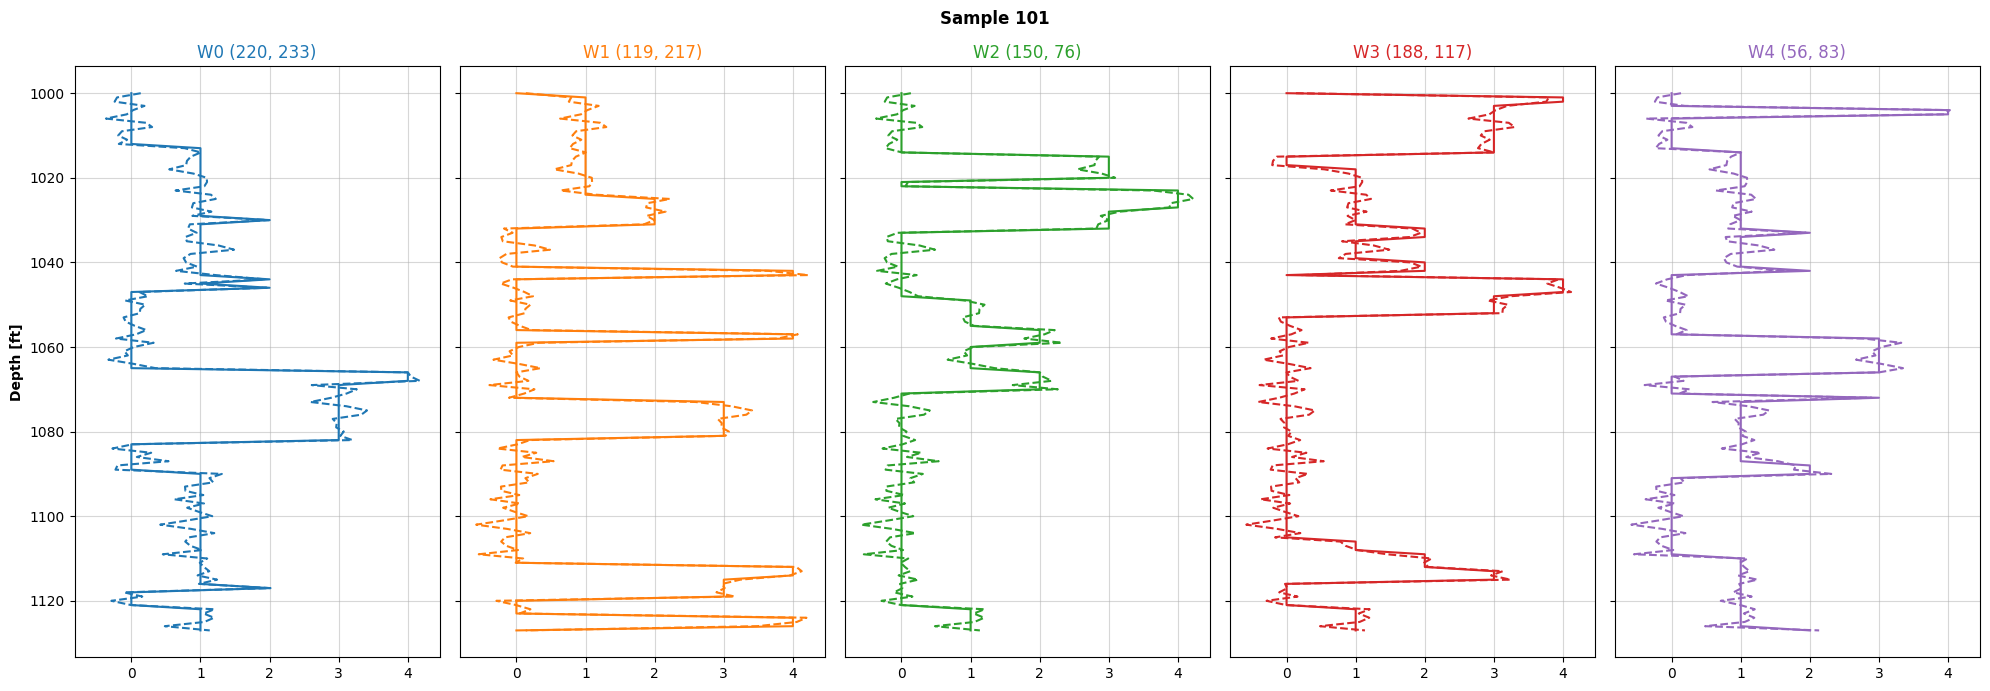

In [7]:
fig, axs = plt.subplots(1, nwells, figsize=(20, 7), sharex=True, sharey=True)
for i, (x, y) in enumerate(zip(wx, wy)):
    axs[i].plot(well_log[i], depth, c='C{}'.format(i))
    axs[i].plot(noise_log[i], depth, c='C{}'.format(i), ls='--')
    axs[i].set_title('W{} ({}, {})'.format(i, x, y), color='C{}'.format(i))
    axs[i].grid(True, which='both', alpha=0.5)
axs[0].invert_yaxis()
axs[0].set_ylabel('Depth [ft]', weight='bold')
plt.suptitle('Sample {}'.format(sample), weight='bold')
plt.tight_layout()
plt.savefig('figures/logs.png', dpi=600)
plt.show()

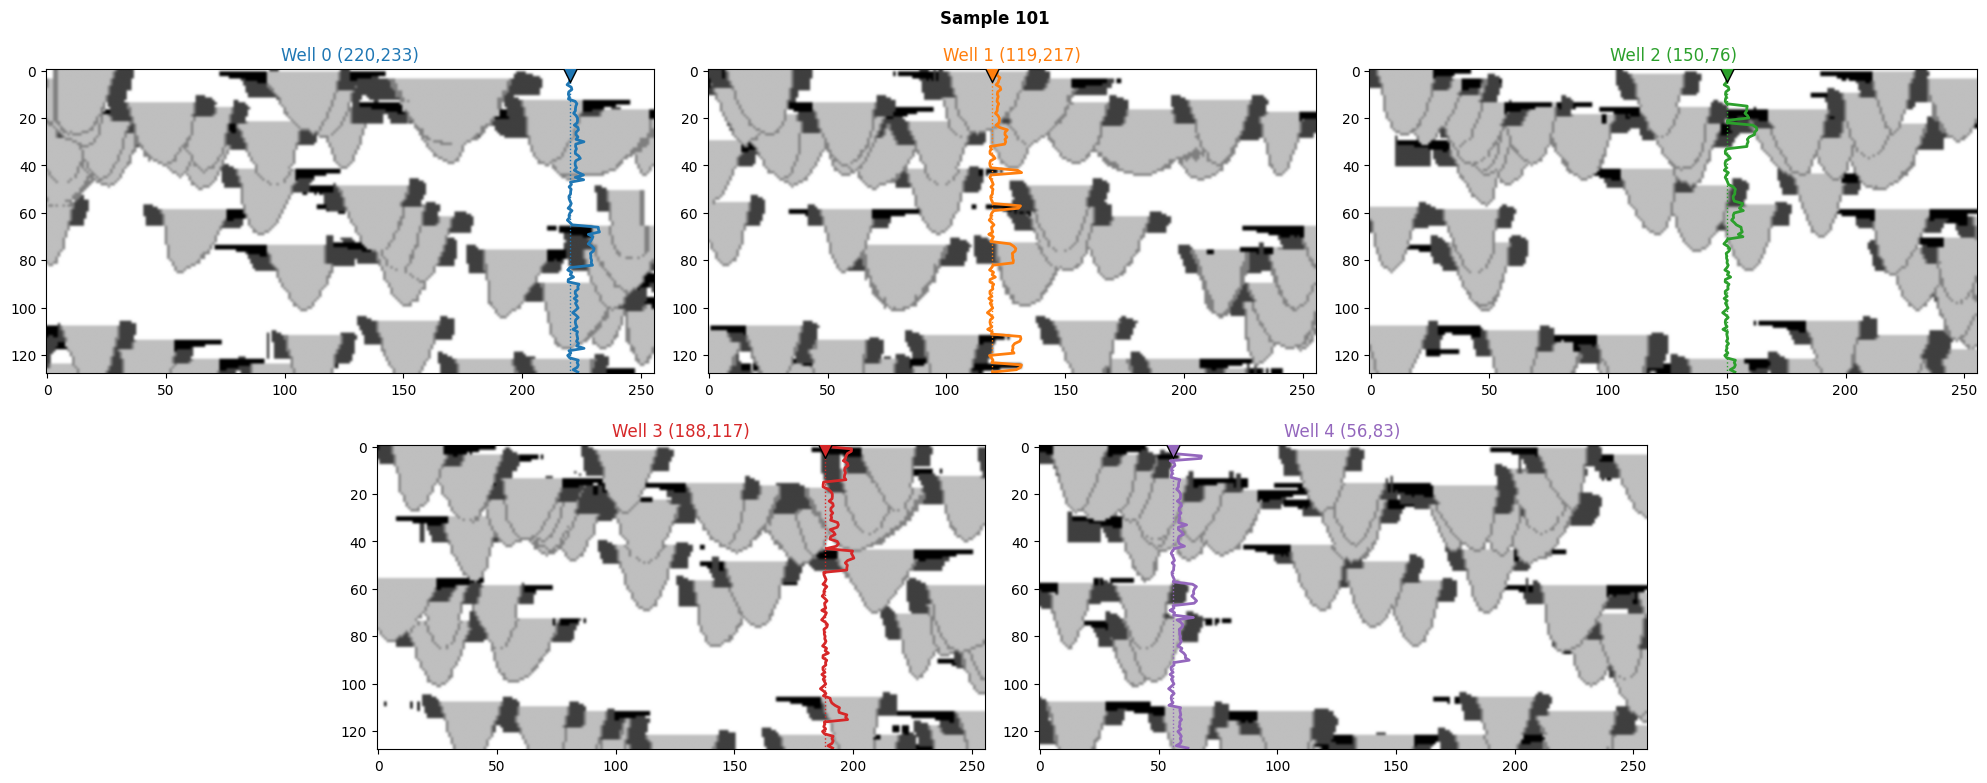

In [ ]:
fig = plt.figure(figsize=(20, 8))
gs = GridSpec(2, 6, figure=fig)
ax1 = fig.add_subplot(gs[0, :2]) 
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:])
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])
axs = [ax1, ax2, ax3, ax4, ax5]

for i, ax in enumerate(axs):
    ax.set_title('Well {} ({},{})'.format(i, wx[i], wy[i]), color='C{}'.format(i))
    ax.imshow(facies[sample, wy[i]].T, cmap=cmap, interpolation=interp)
    ax.scatter(wx[i], 0, c='C{}'.format(i), marker='v', edgecolor='k', s=250, zorder=9)
    ax.plot(np.repeat(wx[i], nz), np.arange(nz), c='C{}'.format(i), lw=1, ls=':')
    ax.plot(np.repeat(wx[i], nz)+wscale*noise_log[i], np.arange(nz), c='C{}'.format(i), lw=2)
plt.suptitle('Sample {}'.format(sample), weight='bold')
plt.tight_layout()
plt.savefig('figures/logs-xsection.png', dpi=600)
plt.show()

***
# END